<a href="https://colab.research.google.com/github/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/08_Classifica%C3%A7%C3%A3o_D%C3%ADgitos_BDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BDT para classificacão de Dígitos

Passo a passo.

### Passo "Zero":
- importar módulos e definir algumas variáveis de controle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

import sklearn
print ( sklearn.__version__ )

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

1.6.1


In [ ]:
train_model = True
run_grid_search = True
save_model = True

model_path = ""
scaler_path = ""
if not train_model:
     model_path = "ada_clf.joblib"
#    model_path = "models/BDT/ada_clf.joblib"
     scaler_path = "standard_scaler.joblib"
#    scaler_path = "models/BDT/standard_scaler.joblib"

### 1º Importar amostra de dígitos

In [ ]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
X_train_raw = mnist.data[:60000]
y_train = mnist.target[:60000]
X_test_raw = mnist.data[60000:]
y_test = mnist.target[60000:]

print ( X_train_raw.shape )
print ( X_test_raw.shape )

(60000, 784)
(10000, 784)


### 2º Renormalização dos dados

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = None
X_train = None
if train_model:
    scaler = StandardScaler()
    X_train = scaler.fit_transform( X_train_raw )
else:
    scaler = load( scaler_path )
    X_train = scaler.transform( X_train_raw )
X_test  = scaler.transform( X_test_raw )

print ( scaler )

if train_model and save_model:
     dump( scaler, "standard_scaler.joblib")
#    dump( scaler, "models/BDT/standard_scaler.joblib" )

idx = 20000
print ( y_train[ idx ] )
print ( X_train[ idx ] )

StandardScaler()
3
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00441808 -0.00575482 -0.00408252 -0.00408252  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00408252 -0.00470969 -0.00879935 -0.01159056
 -0.01475898 -0.01928485 -0.0246718  -0.02907103 -0.03059266 -0.03116401
 -0.03196287 -0.03020254 -0.03131022 -0.0283834  -0.02311919 -0.01916663
 -0.0167723  -0.01099636 -0.00832486 -0.00438069  0.          0.
  0.          0.          0.          0.         -0.00408252 -0.00539535
 -0.00852241 -0.01198504 -0.01765348 -0.0277109  -0.03702009 -0.05215128
 -0.0670362  -0.08301705 -0.0993793  -0.11518413 -0.12913326 -0.13839468
 -0.13888363 -0.13184344 -0.12042952 -0.10189079 -0.0786049  -0.05699561
 -0.03965768 -0.02372839 -0.01408835 -0.00783084  0.          0.
  0.          0

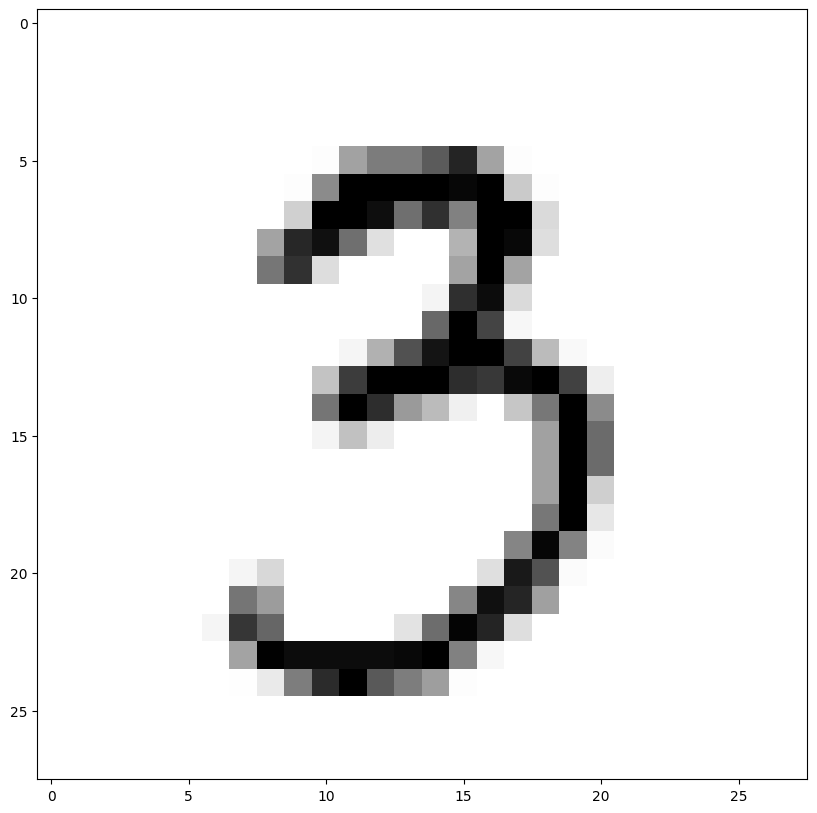

In [ ]:
fig = plt.figure( figsize=(10,10) )
plt.imshow( X_train_raw[ idx ].reshape(28,28), cmap='binary' )

### 3º Treinamento
#### Examinar o espaço dos hyper-parámetros  ("Esquadrinhar")

In [ ]:
#shuffle_index = np.random.permutation( 60000 )
#X_train_shuffle, y_train_shuffle = X_train[ shuffle_index ], y_train[ shuffle_index ]

from sklearn.utils import shuffle
X_train_shuffle, y_train_shuffle = shuffle(X_train,y_train, random_state=42,n_samples=6000)

In [ ]:
n_iter_search = 10 # número de configurações de parâmetros
cv = 3 # cross validation samples
njobs = 5

grid_search = None
if train_model and run_grid_search:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    from sklearn.model_selection import RandomizedSearchCV
    #from sklearn.model_selection import GridSearchCV

    param_distribs = {
        "estimator__max_depth": np.arange(2,5),
        "estimator__min_samples_split": np.arange(2,5),
        "n_estimators": 100 * np.arange(2,6),
        "learning_rate": 0.1 * np.arange(2,6)
        }

    grid_search = RandomizedSearchCV(
        AdaBoostClassifier(
            DecisionTreeClassifier(),
            algorithm="SAMME"
            ),
        param_distribs,
        n_iter=n_iter_search, cv=cv, verbose=20, n_jobs=njobs, random_state=42
        )
    grid_search.fit( X_train_shuffle[:10000], y_train_shuffle[:10000] )

    print ( grid_search.best_params_ )
    print ( grid_search.best_score_ )
    print ( grid_search.cv_results_ )

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2025/04/28 15:47:32
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


{'n_estimators': np.int64(300), 'learning_rate': np.float64(0.30000000000000004), 'estimator__min_samples_split': np.int64(3), 'estimator__max_depth': np.int64(4)}
0.9128333333333334
{'mean_fit_time': array([464.70863032, 393.41519133, 451.89133151, 449.28307827,
       234.56987135, 159.87123148, 278.78568641, 316.54889544,
       417.39876342, 225.57401721]), 'std_fit_time': array([ 1.99129252,  4.60677361,  5.34568479,  5.65045812,  3.60077628,
        1.83704959,  1.8950941 ,  2.9546416 ,  7.82303615, 53.53271422]), 'mean_score_time': array([4.25134857, 6.88396247, 4.94845366, 3.79434013, 3.22542071,
       2.25207408, 2.41472141, 3.83075142, 4.52947481, 2.67728241]), 'std_score_time': array([0.46956799, 0.38085105, 0.16080753, 0.27155956, 0.31471388,
       0.13408979, 0.02286862, 0.40327992, 1.22215292, 2.05932964]), 'param_n_estimators': masked_array(data=[300, 500, 400, 300, 200, 200, 200, 300, 400, 400],
             mask=[False, False, False, False, False, False, False, False

### 4º Treinar o Modelo com os melhores Hyper-parámetros

In [ ]:
model_final = None

if train_model:
    max_depth_ = 4
    min_samples_split_ = 3
    n_estimators_ = 300
    learning_rate_ = 0.3
    if run_grid_search:
#         model_final = grid_search.best_estimator_
        params_ = grid_search.best_params_
        max_depth_ = params_[ 'estimator__max_depth' ]
        min_samples_split_ = params_[ 'estimator__min_samples_split' ]
        n_estimators_ = params_[ 'n_estimators' ]
        learning_rate_ = params_[ 'learning_rate' ]

    model_final = AdaBoostClassifier(
            DecisionTreeClassifier(
                max_depth=max_depth_,
                min_samples_split=min_samples_split_
            ),
            n_estimators = n_estimators_,
            algorithm="SAMME",
            learning_rate = learning_rate_
            )
    model_final.fit( X_train_shuffle, y_train_shuffle )
else:
    model_final = load( model_path )

print ( model_final )

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=np.int64(4),
                                                    min_samples_split=np.int64(3)),
                   learning_rate=np.float64(0.30000000000000004),
                   n_estimators=np.int64(300))


### 5º Testar e avaliar a performance

In [ ]:
y_predict_test = model_final.predict( X_test )

accuracy = np.sum( y_predict_test == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

Accuracy = 0.9255


In [ ]:
probs= model_final.predict_proba(X_test)

In [ ]:
idx=0

print(probs[idx],y_predict_test[idx],y_test[idx])


[0.1044436  0.09880131 0.0999012  0.09967804 0.09921343 0.09986595
 0.09992376 0.09928084 0.09952124 0.09937063] 0 0


In [ ]:
if train_model and save_model:
#     dump( model_final, "ada_clf.joblib" )
    dump( model_final, "ada_clf.joblib" )

In [ ]:
np.info( DecisionTreeClassifier )

 DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None,
                        min_samples_split=2, min_samples_leaf=1,
                        min_weight_fraction_leaf=0.0, max_features=None,
                        random_state=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, class_weight=None,
                        ccp_alpha=0.0, monotonic_cst=None)

A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

In [ ]:
## ROC para o digito "1"

from sklearn.metrics import roc_curve, RocCurveDisplay, auc
fpr, tpr, thresholds = roc_curve(y_test==1, probs[:,1])
roc_auc_1 = auc(fpr, tpr)
print(roc_auc_1)

0.9991131783407997


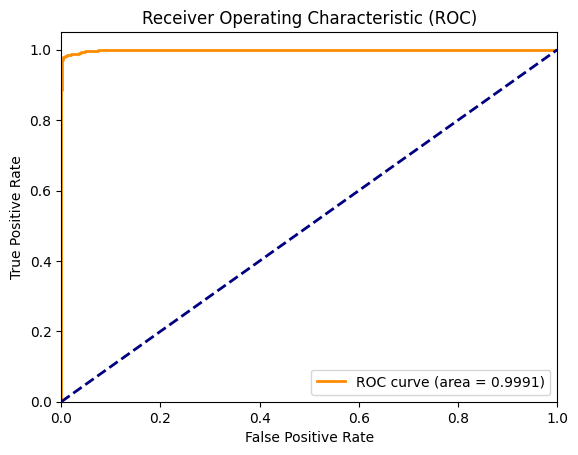

In [ ]:
## Grafico ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



Podemos examinar para outros dígitos, o número corresponde à coluna na matrix entregue pela funcão ```predict_proba```.

#### Exercício :
Coloque todas as ROC curves dos 10 dígitos no mesmo gráfico. Qual dígito tem a pior performance? Qual a melhor?

In [ ]:
## ROC para o digito "0"


fpr, tpr, thresholds = roc_curve(y_test==0, probs[:,0])
roc_auc_0 = auc(fpr, tpr)
print(roc_auc_0)

0.9985730123535002


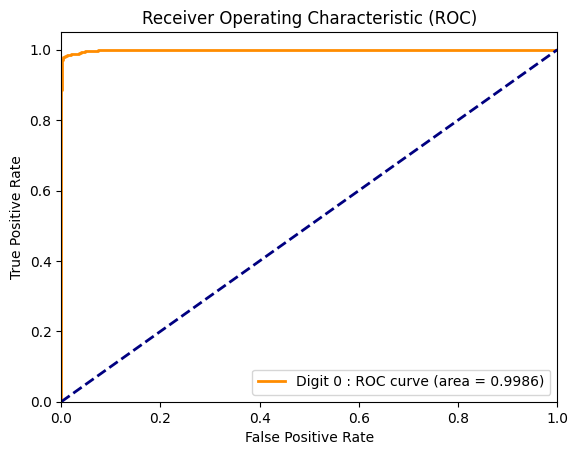

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Digit 0 : ROC curve (area = %0.4f)' % roc_auc_0)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### **Exercício**

Um módulo muito bem sucedido para BDTs é o chamado XGBoost (ou extreme gradient boosting)(Ref: https://github.com/dmlc/xgboost).

Um exemplo de utilização do módulo pode ser encontrado [neste caderno do nosso repositorio](https://github.com/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/Exemplos_BDT/XGB_simple_Classfier.ipynb).

Faça uma adaptacão para usar o XGBoost para fazer a classificação dos dígitos.